In [25]:
from scipy.stats import pearsonr
from transformers import BertModel
import torch
import numpy as np
import os
import matplotlib.pyplot as plt

In [125]:
dataset2tasks = {
    'hwu': ['hwu'],
    'banking': ['banking'],
    'oos': ['oos'],
    'restaurant8k': ['restaurant8k'],
    'top': ['top'],
    'multiwoz21': ['bertnlu', 'trippy', 'tod-dst', 'dap_mwoz'],
    'm2m': ['dap_gsim']
}
# rsa_sim = {}

In [82]:
def get_pretrained_models(dataset):
    pretrained_models_paths = ['/home/data/zhuqi/pre-trained-models/bert-base-uncased',
                               '/home/data/zhuqi/pre-trained-models/dialogbert/dapt/1.0data_0506_lr1e-4_steps40000_bz32ac8_block256_warmup0/checkpoint-39000',
                               '/home/data/zhuqi/pre-trained-models/dialogbert/dapt/0.25data_0517_lr5e-5_steps10000_bz32ac8_block256_warmup0',
                               '/home/data/zhuqi/pre-trained-models/dialogbert/dapt/0.05data_0518_lr2e-5_steps5000_bz32ac8_block256_warmup0/checkpoint-4000',
                               '/home/data/zhuqi/pre-trained-models/dialogbert/dapt/0.01data_0518_lr2e-5_steps1000_bz32ac8_block256_warmup0',
                              ]
    pretrained_models_paths += [x for x in [
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/hwu_0520_lr5e-5_steps1000_bz32ac8_block256_warmup0/checkpoint-700',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/banking_0520_lr5e-5_steps1000_bz32ac8_block256_warmup0',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/oos_0520_lr1e-4_steps1000_bz32ac8_block256_warmup0',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/multiwoz_0519_lr5e-5_steps10000_bz32ac8_block256_warmup0',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/restaurant8k_0520_lr2e-5_steps1000_bz32ac8_block256_warmup0/checkpoint-900',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/top_0520_lr5e-5_steps2000_bz32ac8_block256_warmup0/checkpoint-1800',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/m2m_0520_lr5e-5_steps500_bz32ac8_block256_warmup0/checkpoint-400',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dstc2_0520_lr1e-4_steps1000_bz32ac8_block256_warmup0/checkpoint-600',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_hwu_0524_lr5e-5_steps1000_bz32ac8_block256_warmup0/checkpoint-300',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_banking_0524_lr5e-5_steps1000_bz32ac8_block256_warmup0/checkpoint-600',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_restaurant8k_0524_lr2e-5_steps1000_bz32ac8_block256_warmup0/checkpoint-300',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_top_0524_lr5e-5_steps2000_bz32ac8_block256_warmup0/checkpoint-1900',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_multiwoz_0524_lr5e-5_steps10000_bz32ac8_block256_warmup0/checkpoint-4100',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_oos_0524_lr1e-4_steps1000_bz32ac8_block256_warmup0/checkpoint-1000',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_m2m_0524_lr5e-5_steps500_bz32ac8_block256_warmup0/checkpoint-200',
       '/home/data/zhuqi/pre-trained-models/dialogbert/tapt/dapt_dstc2_0524_lr1e-4_steps1000_bz32ac8_block256_warmup0/checkpoint-400',
    ] if dataset in x or (dataset=='multiwoz21' and 'multiwoz' in x)]
    pretrained_models = {}
    for model_path in pretrained_models_paths:
        if 'checkpoint' in model_path.split('/')[-1]:
            model_path = os.path.dirname(model_path)
        if 'dapt' in model_path.split('/')[-1]:
            model_name = 'dapt_tapt'
        elif 'bert' in model_path.split('/')[-1]:
            model_name = 'bert'
        elif 'dapt' in model_path.split('/')[-2] and '1.0data' not in model_path.split('/')[-1]:
            model_name = 'dapt_' + model_path.split('/')[-1].split('_')[0]
        else:
            model_name = model_path.split('/')[-2]
        model_path = model_path.split('/')[-1]
        pretrained_models[model_name] = model_path
#     print(pretrained_models)
    return pretrained_models

In [108]:
def get_ft_models(ft_tasks):
    ft_models = {}
    for ft_task in ft_tasks:
        for root, dirs, files in os.walk('/home/data/zhuqi/pre-trained-models/dialogbert/ft/'+ft_task):
            for dir_name in dirs:
                ft_models['ft_{}_{}'.format(ft_task, dir_name)] = os.path.join(root, dir_name)
#     print(ft_models)
    return ft_models

## BERT vs BERT-DAPT/TAPT/DAPT+TAPT
- DAPT数据越少，相对bert的改变越小。
- multiwoz数据集上改变的较多。
- TAPT一般弱于DAPT，DAPT+TAPT与DAPT很相似，常介于DAPT和TAPT之间。
- 前9层的相关系数都在0.6以上，前6层最低在0.8左右

In [ ]:
for dataset in dataset2tasks:
    rsa_sim.setdefault(dataset, {})
    
    pretrained_models = get_pretrained_models(dataset)

    for i in range(12):
        for model_a in ['bert']:
            rsa_sim[dataset].setdefault(model_a, {})
            model_a_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, pretrained_models[model_a]))
            for model_b in ['dapt', 'dapt_0.25data', 'dapt_0.05data', 'dapt_0.01data', 'tapt', 'dapt_tapt']:
                model_b_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, pretrained_models[model_b]))
                rsa_sim[dataset][model_a].setdefault(model_b, [])
                rsa_sim[dataset][model_a][model_b].append(pearsonr(model_a_sim, model_b_sim)[0])

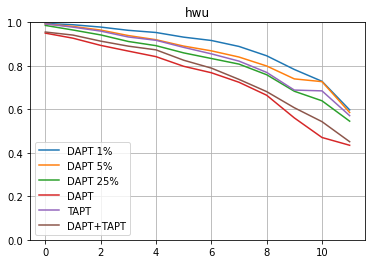

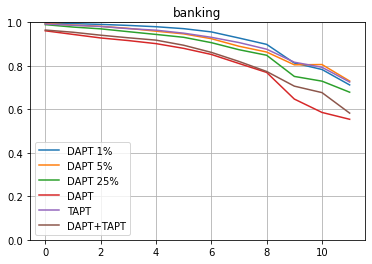

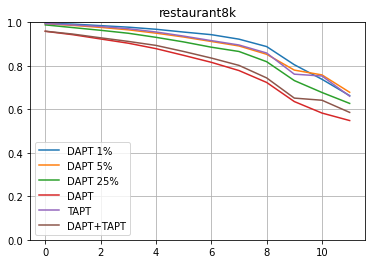

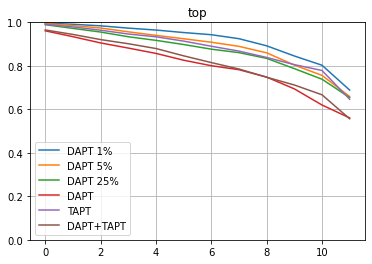

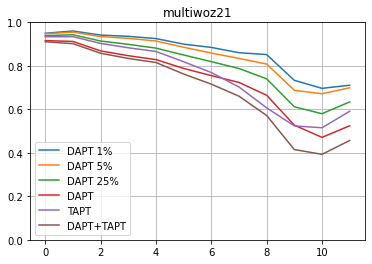

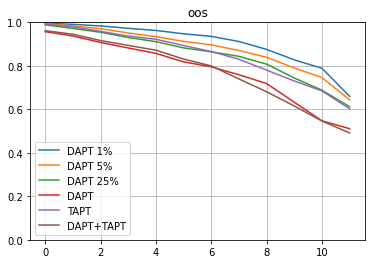

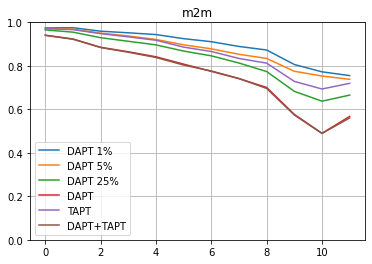

In [84]:
for dataset in dataset2tasks:
    plt.plot(range(12), rsa_sim[dataset]['bert']['dapt_0.01data'], label='DAPT 1%')
    plt.plot(range(12), rsa_sim[dataset]['bert']['dapt_0.05data'], label='DAPT 5%')
    plt.plot(range(12), rsa_sim[dataset]['bert']['dapt_0.25data'], label='DAPT 25%')
    plt.plot(range(12), rsa_sim[dataset]['bert']['dapt'], label='DAPT')
    plt.plot(range(12), rsa_sim[dataset]['bert']['tapt'], label='TAPT')
    plt.plot(range(12), rsa_sim[dataset]['bert']['dapt_tapt'], label='DAPT+TAPT')
    plt.legend(loc='lower left')
    plt.ylim(0,1)
    plt.title(dataset)
    plt.grid()
    plt.show()

## Full-data FT对模型表示空间的影响
- 相比于继续预训练，后几层的变化更显著
- 数据较多的multiwoz，前几层的变化比其他数据集大
- 不同初始化，FT带来的变化程度相似，和ft性能没什么关系

In [ ]:
for dataset in dataset2tasks:
    rsa_sim.setdefault(dataset, {})
    ft_tasks = dataset2tasks[dataset]
    
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    print(dataset)

    for i in range(12):
        for model_a in pretrained_models:
            rsa_sim[dataset].setdefault(model_a, {})
            model_a_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, pretrained_models[model_a]))
            for ft_task in ft_tasks:
                model_b = '-'.join(ft_models['ft_{}_{}'.format(ft_task, model_a)].split('/')[-3:])
                model_b_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, model_b))
                if i == 0:
                    rsa_sim[dataset][model_a][model_b] = []
                    print('\t', model_a, model_b)
                rsa_sim[dataset][model_a][model_b].append(pearsonr(model_a_sim, model_b_sim)[0])

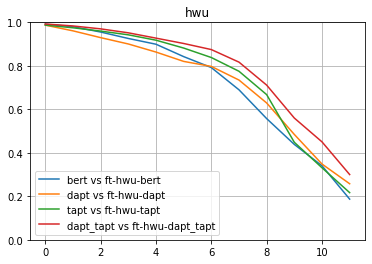

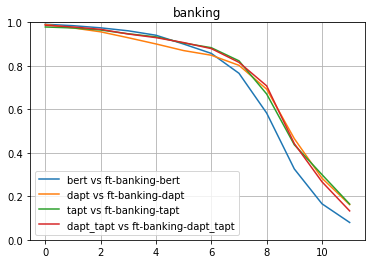

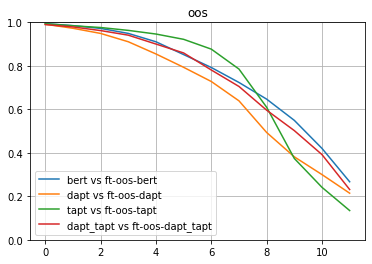

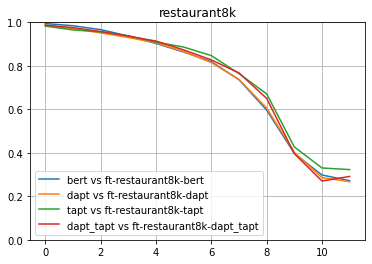

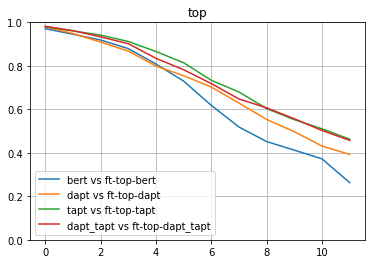

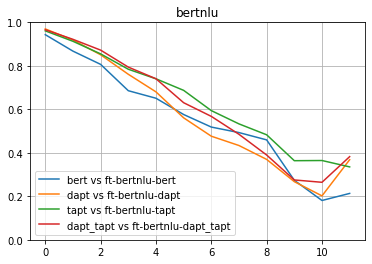

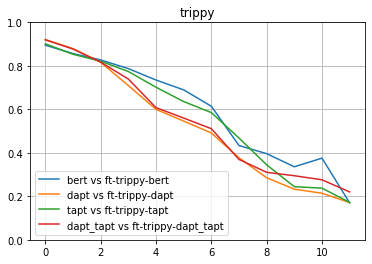

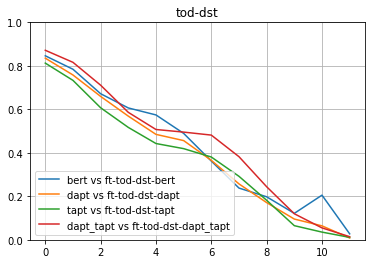

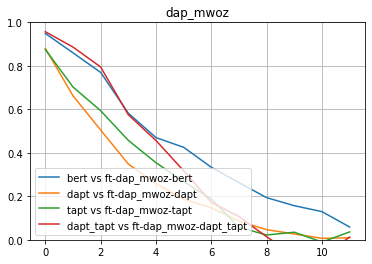

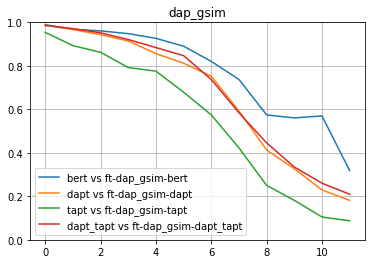

In [149]:
for dataset in dataset2tasks:
    rsa_sim.setdefault(dataset, {})
    ft_tasks = dataset2tasks[dataset]
    
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    
    for ft_task in ft_tasks:
        for model_a in pretrained_models:
            model_b = '-'.join(ft_models['ft_{}_{}'.format(ft_task, model_a)].split('/')[-3:])
            if model_a.endswith('data'):
                continue
#             if not model_a.endswith('data') and model_a!='dapt':
#                 continue
            plt.plot(range(12), rsa_sim[dataset][model_a][model_b], label='{} vs {}'.format(model_a, model_b))
#         plt.plot(range(12), rsa_sim[dataset]['bert']['dapt'], label='DAPT')
#         plt.plot(range(12), rsa_sim[dataset]['bert']['tapt'], label='TAPT')
#         plt.plot(range(12), rsa_sim[dataset]['bert']['dapt_tapt'], label='DAPT+TAPT')
        plt.legend(loc='lower left')
        plt.ylim(0,1)
        plt.title(ft_task)
        plt.grid()
        plt.show()

## Low-resource
- 一般情况，数据增多，相关性降低，前几层比较一致，后几层变化较大可能不一定
- 

In [ ]:
for dataset in dataset2tasks:
    rsa_sim.setdefault(dataset, {})
    ft_tasks = dataset2tasks[dataset]
    
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    print(dataset)

    for i in range(12):
        for model_a in pretrained_models:
            rsa_sim[dataset].setdefault(model_a, {})
            model_a_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, pretrained_models[model_a]))
            for ft_task in ft_tasks:
                for data_ratio in ['_0.1data', '_0.01data']:
                    if 'ft_{}{}_{}'.format(ft_task, data_ratio, model_a) not in ft_models:
                        continue
                    model_b = '-'.join(ft_models['ft_{}{}_{}'.format(ft_task, data_ratio, model_a)].split('/')[-3:])
                    model_b_sim = np.load('rsa_test_output/{}_layer{}_{}.npy'.format(dataset, i, model_b))
                    if i == 0:
                        rsa_sim[dataset][model_a][model_b] = []
                        print('\t', model_a, model_b)
                    rsa_sim[dataset][model_a][model_b].append(pearsonr(model_a_sim, model_b_sim)[0])

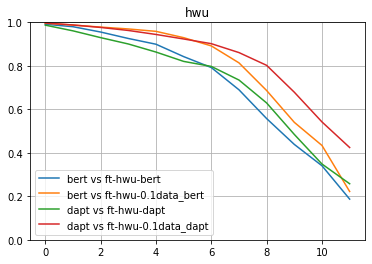

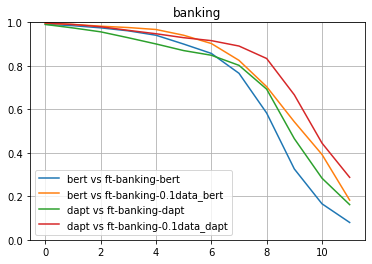

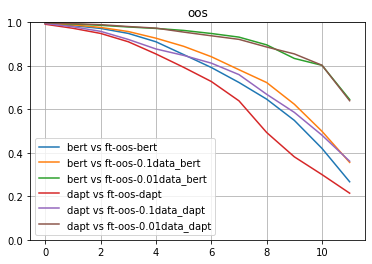

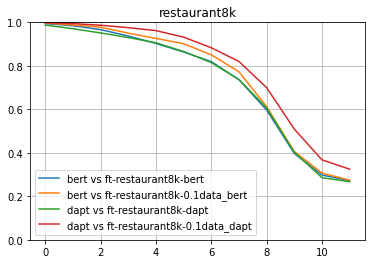

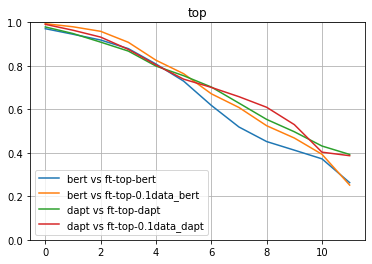

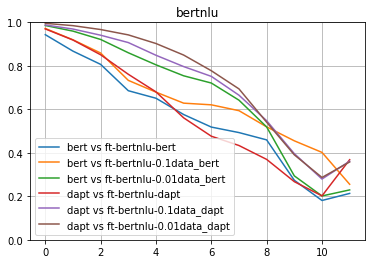

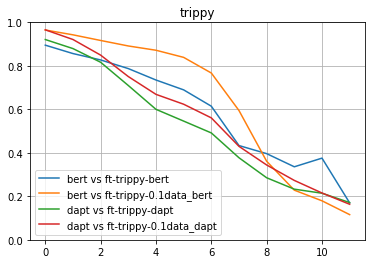

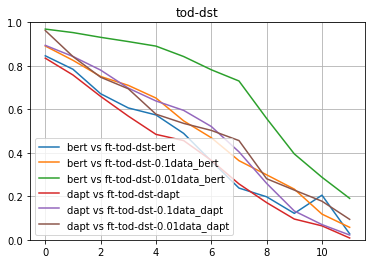

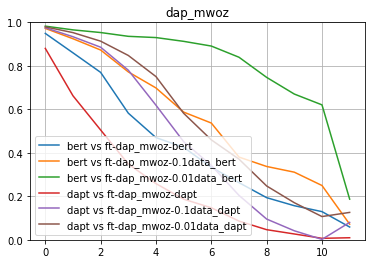

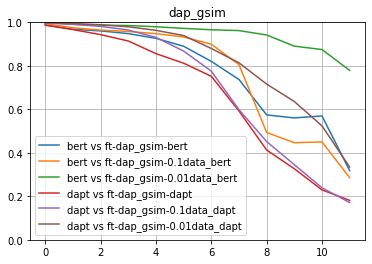

In [151]:
for dataset in dataset2tasks:
    rsa_sim.setdefault(dataset, {})
    ft_tasks = dataset2tasks[dataset]
    
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    
    for ft_task in ft_tasks:
        for model_a in pretrained_models:
#             if 'tapt' in model_a:
#                 continue
            if 'tapt' in model_a or model_a.endswith('data'):
                continue
            for data_ratio in ['', '_0.1data', '_0.01data']:
                if 'ft_{}{}_{}'.format(ft_task, data_ratio, model_a) not in ft_models:
                    continue
                model_b = '-'.join(ft_models['ft_{}{}_{}'.format(ft_task, data_ratio, model_a)].split('/')[-3:])
                plt.plot(range(12), rsa_sim[dataset][model_a][model_b], label='{} vs {}'.format(model_a, model_b))
        plt.legend(loc='lower left')
        plt.ylim(0,1)
        plt.title(ft_task)
        plt.grid()
        plt.show()

In [136]:
ft_models

{'ft_hwu_0.1data_tapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/0.1data_tapt',
 'ft_hwu_dapt_tapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/dapt_tapt',
 'ft_hwu_0.1data_dapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/0.1data_dapt',
 'ft_hwu_dapt_0.01data': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/dapt_0.01data',
 'ft_hwu_0.1data_dapt_tapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/0.1data_dapt_tapt',
 'ft_hwu_dapt_0.05data': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/dapt_0.05data',
 'ft_hwu_dapt_0.25data': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/dapt_0.25data',
 'ft_hwu_tapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/tapt',
 'ft_hwu_dapt': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/dapt',
 'ft_hwu_0.1data_bert': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/0.1data_bert',
 'ft_hwu_bert': '/home/data/zhuqi/pre-trained-models/dialogbert/ft/hwu/bert'}

In [175]:
np.mean([0.7416500774165008, 0.7508294625082946, 0.7363415173634151])

0.7429403524294035

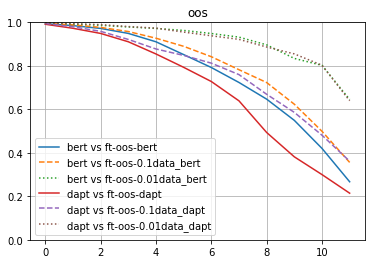

In [185]:
for dataset in ['oos']:
    rsa_sim.setdefault(dataset, {})
    ft_tasks = dataset2tasks[dataset]
    
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    
    for ft_task in ft_tasks:
        for model_a in pretrained_models:
#             if 'tapt' in model_a:
#                 continue
            if 'tapt' in model_a or model_a.endswith('data'):
                continue
            for data_ratio, ls in zip(['', '_0.1data', '_0.01data'],['-','--',':']):
                if 'ft_{}{}_{}'.format(ft_task, data_ratio, model_a) not in ft_models:
                    continue
                model_b = '-'.join(ft_models['ft_{}{}_{}'.format(ft_task, data_ratio, model_a)].split('/')[-3:])
                plt.plot(range(12), rsa_sim[dataset][model_a][model_b], label='{} vs {}'.format(model_a, model_b), linestyle=ls)
        plt.legend(loc='lower left')
        plt.ylim(0,1)
        plt.title(ft_task)
        plt.grid()
        plt.show()

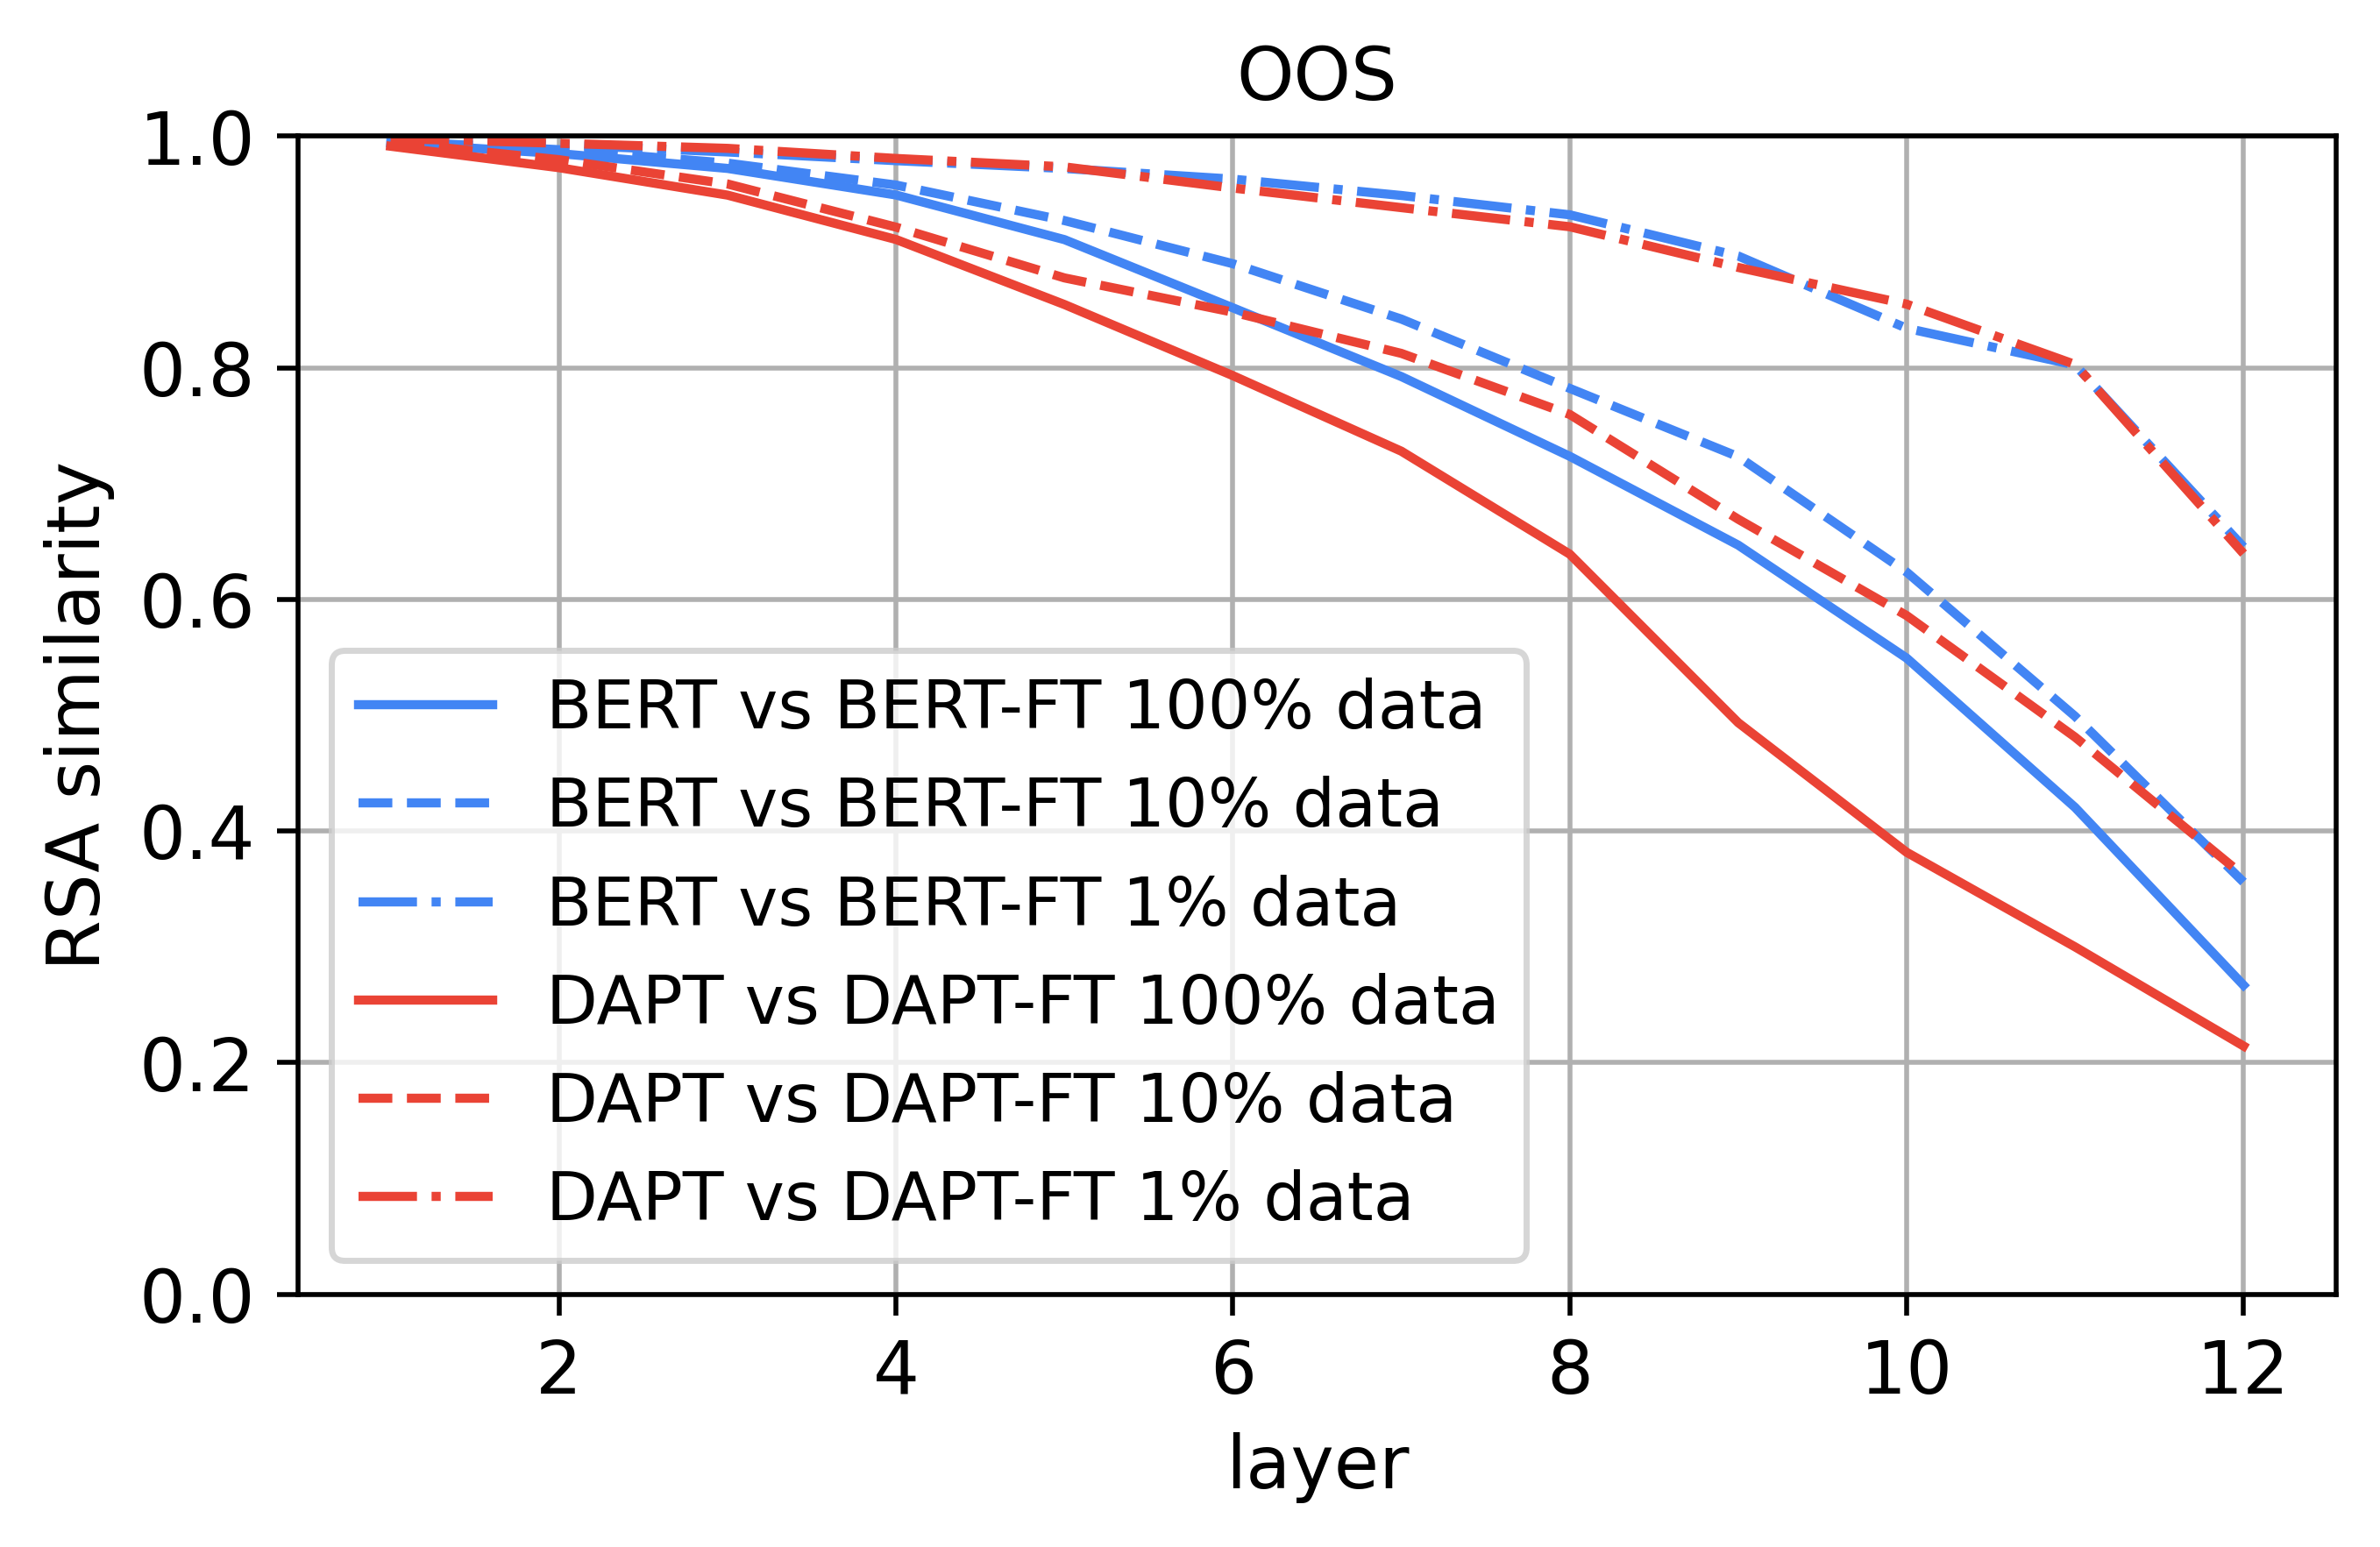

In [262]:
plt.figure(figsize=(6,3.5), dpi=500)
plt.plot(range(1,13), rsa_sim['oos']['bert']['ft-oos-bert'], label='{} vs {}'.format('BERT', 'BERT-FT 100% data'), linestyle='-', color='#4285f4')
plt.plot(range(1,13), rsa_sim['oos']['bert']['ft-oos-0.1data_bert'], label='{} vs {}'.format('BERT', 'BERT-FT 10% data'), linestyle='--', color='#4285f4')
plt.plot(range(1,13), rsa_sim['oos']['bert']['ft-oos-0.01data_bert'], label='{} vs {}'.format('BERT', 'BERT-FT 1% data'), linestyle='-.', color='#4285f4')
plt.plot(range(1,13), rsa_sim['oos']['dapt']['ft-oos-dapt'], label='{} vs {}'.format('DAPT', 'DAPT-FT 100% data'), linestyle='-', color='#ea4335')

plt.plot(range(1,13), rsa_sim['oos']['dapt']['ft-oos-0.1data_dapt'], label='{} vs {}'.format('DAPT', 'DAPT-FT 10% data'), linestyle='--', color='#ea4335')

plt.plot(range(1,13), rsa_sim['oos']['dapt']['ft-oos-0.01data_dapt'], label='{} vs {}'.format('DAPT', 'DAPT-FT 1% data'), linestyle='-.', color='#ea4335')
plt.legend(loc='lower left',fontsize=11)
plt.ylim(0,1)
plt.ylabel('RSA similarity',fontsize=12)
plt.xlabel('layer',fontsize=12)
plt.title('OOS')
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.grid()
plt.show()

In [227]:
np.mean([34.88, 35.5, 36.77])

35.71666666666667

hwu bert ft-hwu-bert 0.7166956209463443
hwu bert ft-hwu-0.1data_bert 0.7840092933929718
hwu dapt ft-hwu-dapt 0.7262105571848596
hwu dapt ft-hwu-0.1data_dapt 0.8335650990460092


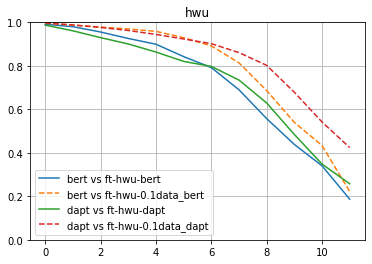

banking bert ft-banking-bert 0.7108265554970413
banking bert ft-banking-0.1data_bert 0.7835533852110301
banking dapt ft-banking-dapt 0.7396362816148057
banking dapt ft-banking-0.1data_dapt 0.8206284057583241


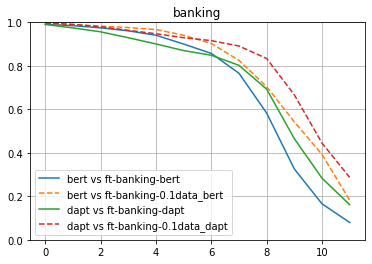

oos bert ft-oos-bert 0.7551788005982264
oos bert ft-oos-0.1data_bert 0.7967875558061878
oos bert ft-oos-0.01data_bert 0.9123729033268204
oos dapt ft-oos-dapt 0.6856848396637997
oos dapt ft-oos-0.1data_dapt 0.7708398639463634
oos dapt ft-oos-0.01data_dapt 0.9112389782818986


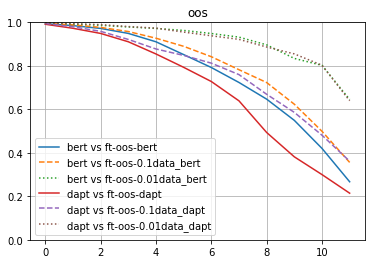

restaurant8k bert ft-restaurant8k-bert 0.7307735004252538
restaurant8k bert ft-restaurant8k-0.1data_bert 0.7469972489500248
restaurant8k dapt ft-restaurant8k-dapt 0.7271022557377654
restaurant8k dapt ft-restaurant8k-0.1data_dapt 0.7878027294519786


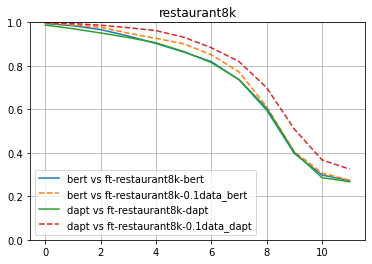

top bert ft-top-bert 0.6573863204102581
top bert ft-top-0.1data_bert 0.6956678588039481
top dapt ft-top-dapt 0.7053145377988735
top dapt ft-top-0.1data_dapt 0.7161425562283222


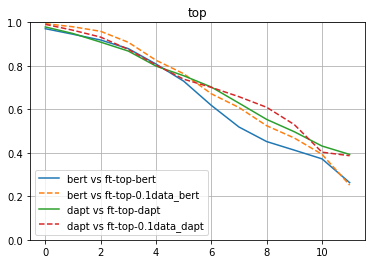

multiwoz21 bert ft-bertnlu-bert 0.5557875707476932
multiwoz21 bert ft-bertnlu-0.1data_bert 0.6364894744459982
multiwoz21 bert ft-bertnlu-0.01data_bert 0.65774224155958
multiwoz21 dapt ft-bertnlu-dapt 0.5716390779345197
multiwoz21 dapt ft-bertnlu-0.1data_dapt 0.7043582198465659
multiwoz21 dapt ft-bertnlu-0.01data_dapt 0.7241693253748062


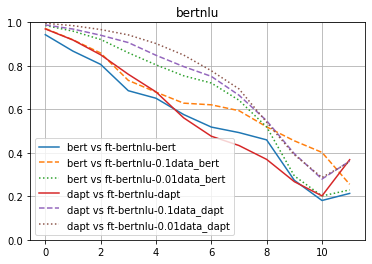

multiwoz21 bert ft-trippy-bert 0.5929778315374375
multiwoz21 bert ft-trippy-0.1data_bert 0.6393829590037802
multiwoz21 dapt ft-trippy-dapt 0.5204126847983618
multiwoz21 dapt ft-trippy-0.1data_dapt 0.5638017777180307


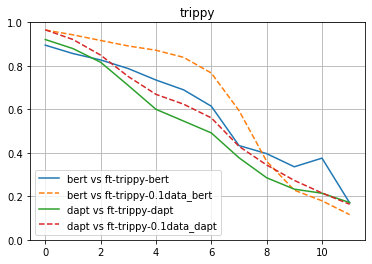

multiwoz21 bert ft-tod-dst-bert 0.42706058913741957
multiwoz21 bert ft-tod-dst-0.1data_bert 0.49312908217781454
multiwoz21 bert ft-tod-dst-0.01data_bert 0.7034862548463647
multiwoz21 dapt ft-tod-dst-dapt 0.39365778943223506
multiwoz21 dapt ft-tod-dst-0.1data_dapt 0.48821330791680534
multiwoz21 dapt ft-tod-dst-0.01data_dapt 0.5084031766060795


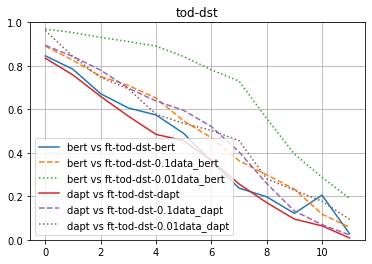

multiwoz21 bert ft-dap_mwoz-bert 0.4326815091481883
multiwoz21 bert ft-dap_mwoz-0.1data_bert 0.5595628210689096
multiwoz21 bert ft-dap_mwoz-0.01data_bert 0.8029297668794312
multiwoz21 dapt ft-dap_mwoz-dapt 0.2637012535914439
multiwoz21 dapt ft-dap_mwoz-0.1data_dapt 0.4508628527746905
multiwoz21 dapt ft-dap_mwoz-0.01data_dapt 0.5422958226256757


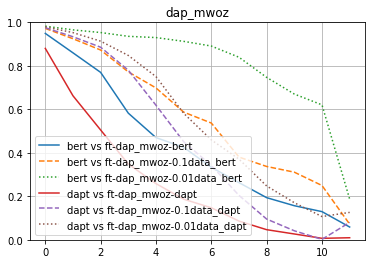

m2m bert ft-dap_gsim-bert 0.7719536073192438
m2m bert ft-dap_gsim-0.1data_bert 0.7628160713899441
m2m bert ft-dap_gsim-0.01data_bert 0.9441261857126438
m2m dapt ft-dap_gsim-dapt 0.6645284772854104
m2m dapt ft-dap_gsim-0.1data_dapt 0.6928989124602082
m2m dapt ft-dap_gsim-0.01data_dapt 0.8140610557636822


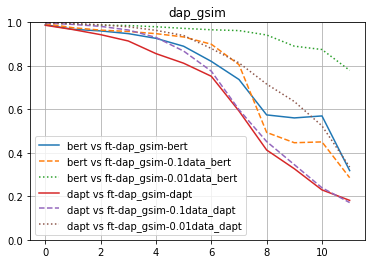

In [239]:
for dataset in dataset2tasks:
    ft_tasks = dataset2tasks[dataset]
    pretrained_models = get_pretrained_models(dataset)
    ft_models = get_ft_models(ft_tasks)
    for ft_task in ft_tasks:
        for model_a in pretrained_models:
#             if 'tapt' in model_a:
#                 continue
            if 'tapt' in model_a or model_a.endswith('data'):
                continue
            for data_ratio, ls in zip(['', '_0.1data', '_0.01data'],['-','--',':']):
                if 'ft_{}{}_{}'.format(ft_task, data_ratio, model_a) not in ft_models:
                    continue
                model_b = '-'.join(ft_models['ft_{}{}_{}'.format(ft_task, data_ratio, model_a)].split('/')[-3:])
                plt.plot(range(12), rsa_sim[dataset][model_a][model_b], label='{} vs {}'.format(model_a, model_b), linestyle=ls)
                print(dataset, model_a, model_b, np.mean(rsa_sim[dataset][model_a][model_b]))
        plt.legend(loc='lower left')
        plt.ylim(0,1)
        plt.title(ft_task)
        plt.grid()
        plt.show()

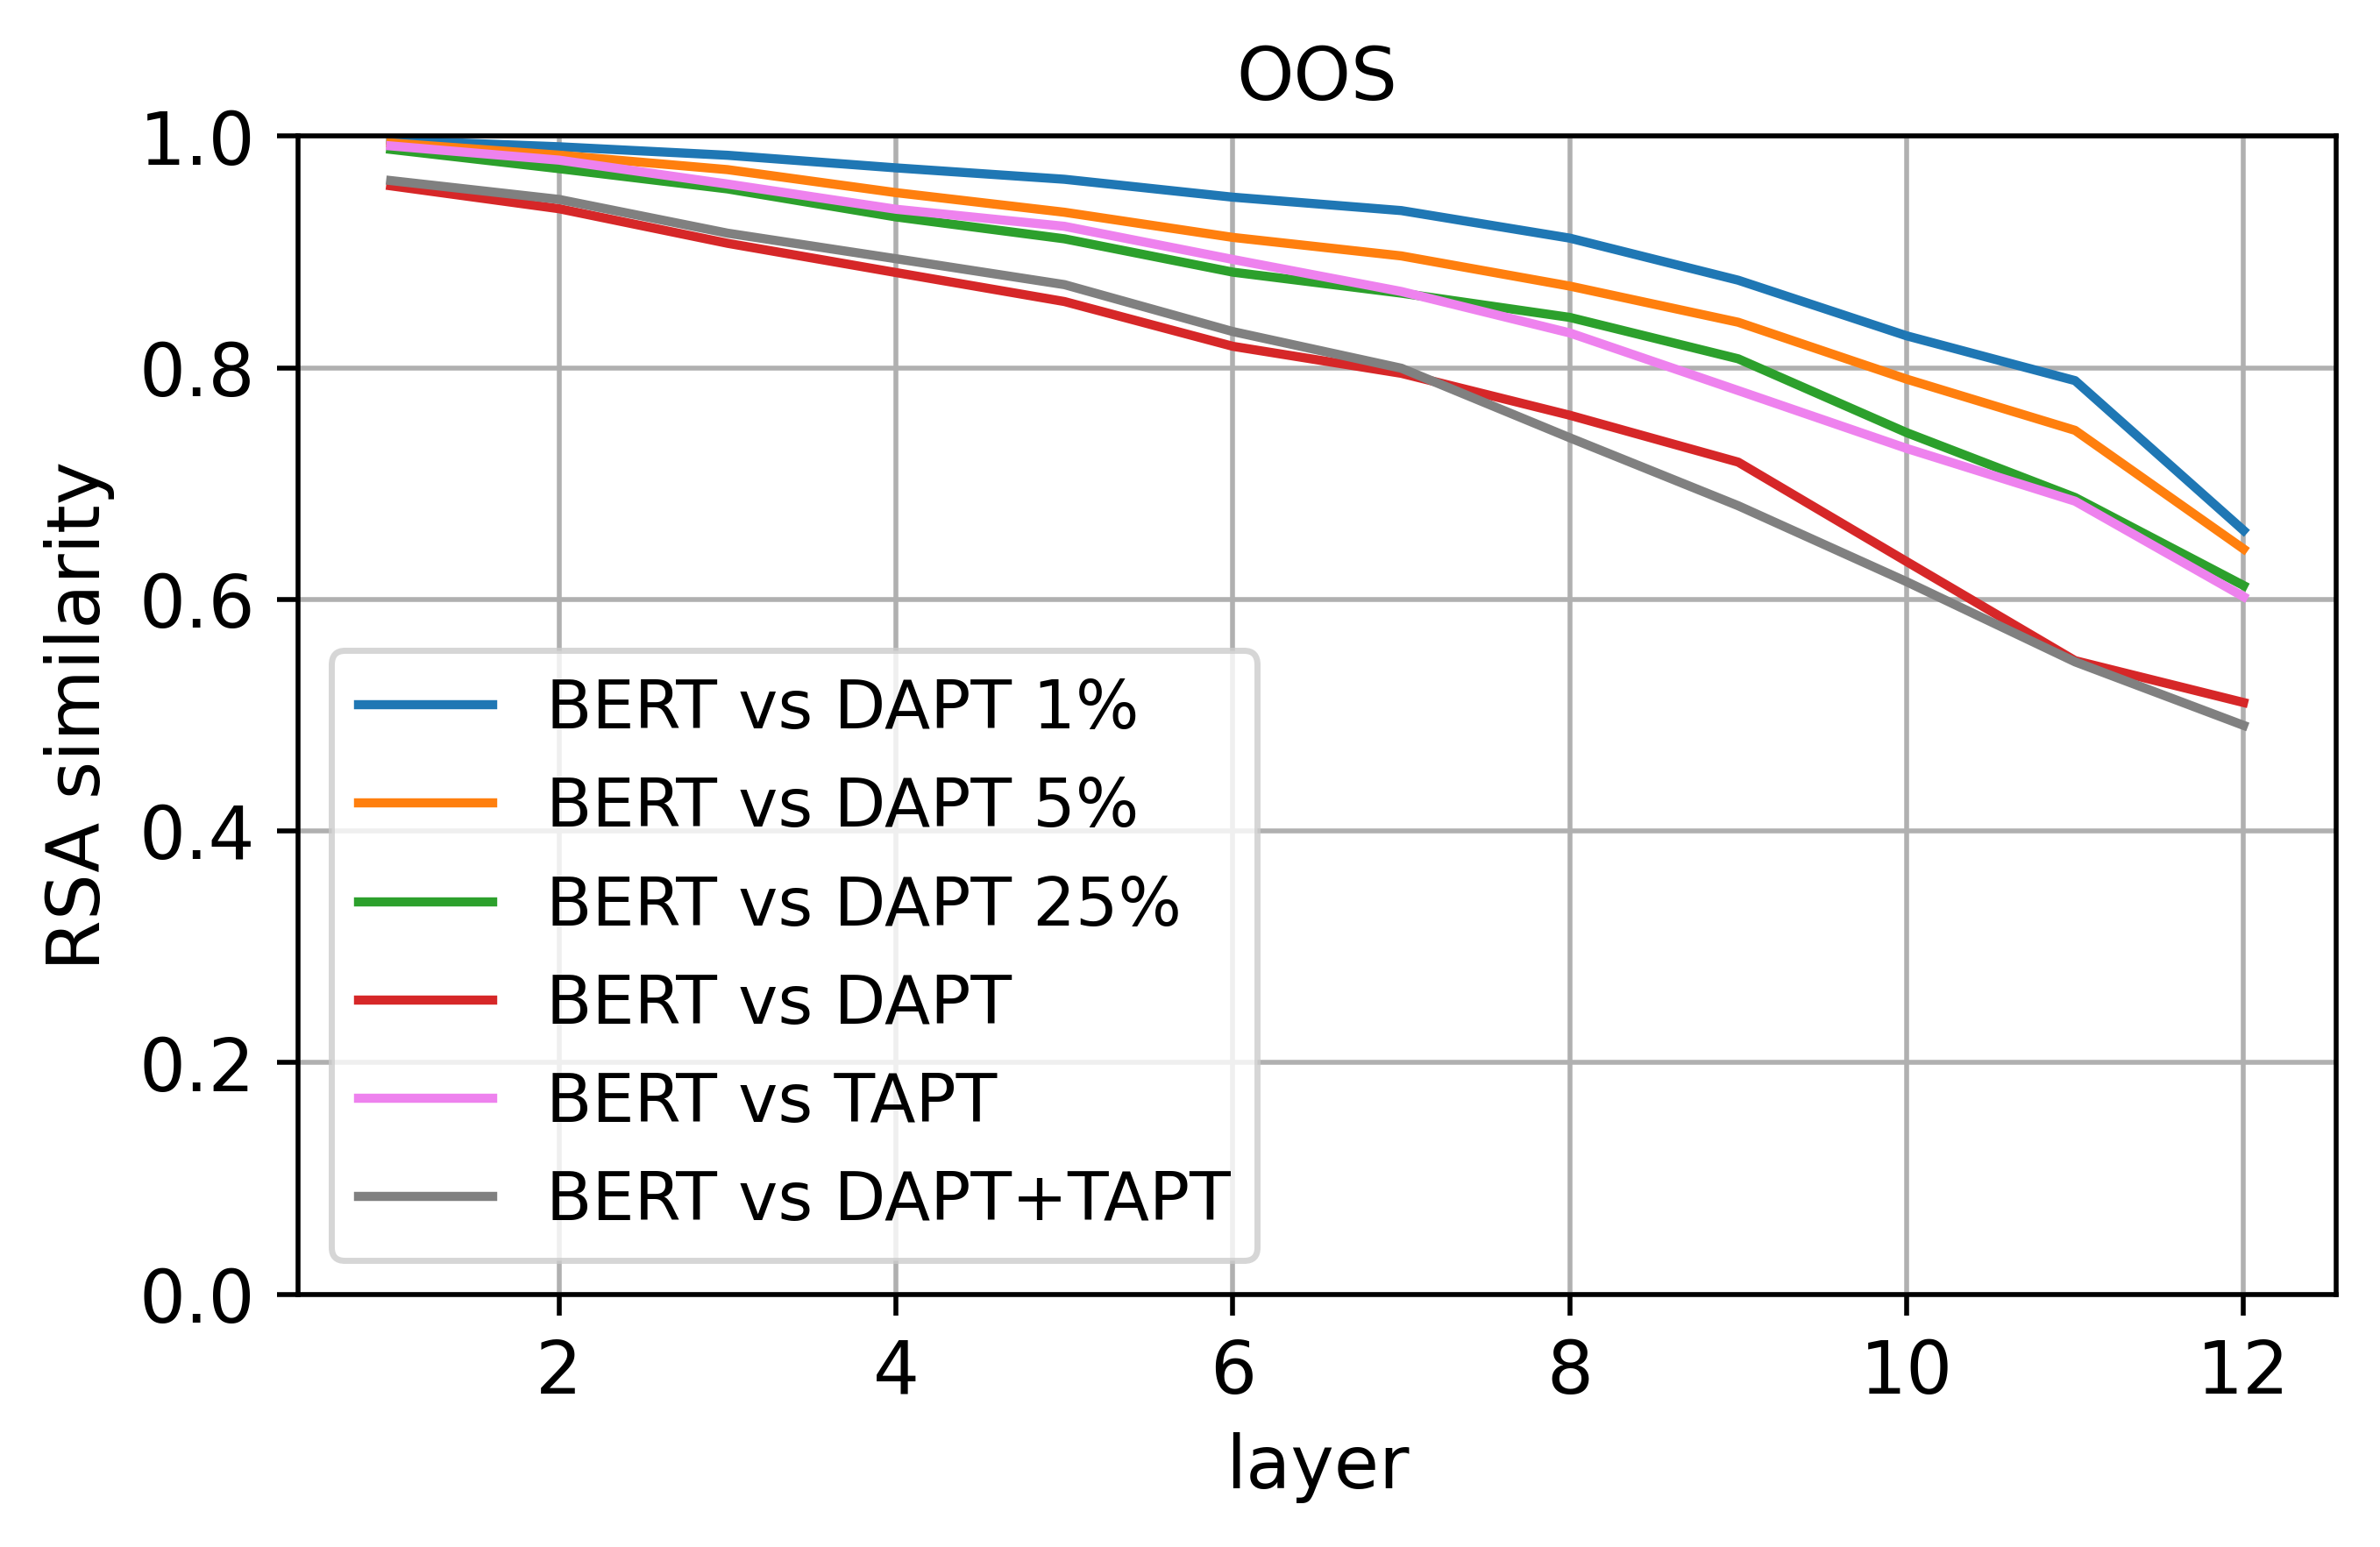

<Figure size 432x288 with 0 Axes>

In [261]:
for dataset in ['oos']:
    plt.figure(figsize=(6,3.5), dpi=500)
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['dapt_0.01data'], label='BERT vs DAPT 1%')
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['dapt_0.05data'], label='BERT vs DAPT 5%')
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['dapt_0.25data'], label='BERT vs DAPT 25%')
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['dapt'], label='BERT vs DAPT')
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['tapt'], label='BERT vs TAPT', color='violet')
    plt.plot(range(1,13), rsa_sim[dataset]['bert']['dapt_tapt'], label='BERT vs DAPT+TAPT', color='gray')
    plt.legend(loc='lower left',fontsize=11)
    plt.ylim(0,1)
    plt.ylabel('RSA similarity',fontsize=12)
    plt.xlabel('layer',fontsize=12)
    plt.title('OOS')
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.grid()
    plt.show()
    plt.savefig('RSA_dapt.pdf')